In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory


Data Preperation

In [3]:
# path for each partition of the data
data_directory = pathlib.Path('/Users/erdem/model-playground/data')

# creating a pathlib object for each partition
train_subdir = data_directory.joinpath("train")
validation_subdir = data_directory.joinpath("valid")
test_subdir = data_directory.joinpath("test")

training_images = [file for subdir in train_subdir.glob('*') for file in subdir.glob('*')]
validation_images = [file for subdir in validation_subdir.glob('*') for file in subdir.glob('*')]
test_images = [file for subdir in test_subdir.glob('*') for file in subdir.glob('*')]

print(f"Number of training examples: {len(training_images)}",
      f"\nNumber of validation examples: {len(validation_images)}",
f"\nNumber of test examples: {len(test_images)}")


Number of training examples: 5000 
Number of validation examples: 899 
Number of test examples: 902


In [4]:
batch_size = 32
target_size = (224,224)

# creating the training, validation and test sets
train_set= image_dataset_from_directory(
    train_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

validation_set= image_dataset_from_directory(
    validation_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

test_set = image_dataset_from_directory(
    test_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

Found 5000 files belonging to 5 classes.
Found 899 files belonging to 5 classes.
Found 902 files belonging to 5 classes.


In [5]:
data_augmentation =  tf.keras.Sequential([
    layers.RandomRotation(factor=0.1),  # Random rotation (up to 20%)
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),  # Random zoom
    layers.RandomFlip(mode="horizontal"),  # Random horizontal flip
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
    layers.RandomContrast(factor=0.2),  # Random contrast adjustment
    layers.RandomBrightness(factor=0.2),  # Random brightness adjustment
])


In [6]:
inception_base_model = InceptionV3(
    include_top=False,
    weights="/Users/erdem/model-playground/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=(224, 224, 3)
)
global_average_layer = layers.GlobalAveragePooling2D()


# building the model
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented = data_augmentation(inputs)
features_extracted = inception_base_model(augmented)
avg_pooling = global_average_layer(features_extracted)
dropout = tf.keras.layers.Dropout(0.3)(avg_pooling)
outputs = layers.Dense(5, activation='softmax')(dropout)
model_densenet = tf.keras.Model(inputs, outputs)
model_inception = tf.keras.Model(inputs, outputs)
model_inception.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 21,778,597 (83.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [7]:
#Compile the model with Adam optimizer and sparse categorical crossentropy loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5,  min_lr=1e-6)

model_inception.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
#Train the model
EPOCHS = 20

history_inception = model_inception.fit(
    train_set,
    validation_data=validation_set,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_plateau]
)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.5345 - loss: 1.1879 - val_accuracy: 0.2547 - val_loss: 2.2852 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.6648 - loss: 0.8579 - val_accuracy: 0.5350 - val_loss: 1.3185 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7030 - loss: 0.7730 - val_accuracy: 0.5228 - val_loss: 1.3374 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.7112 - loss: 0.7161 - val_accuracy: 0.6151 - val_loss: 1.2508 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.7254 - loss: 0.6984 - val_accuracy: 0.5551 - val_loss: 1.2345 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7522 - loss: 0.6411 - val_accuracy: 0.6274 - val_loss: 0.9583 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.7619 - loss: 0.

In [9]:
model_comparison = {}
model_comparison['inception'] = pd.DataFrame(history_inception.history)

In [10]:
def plot_performance(model_name, epochs = EPOCHS):
  dataframe = model_comparison[model_name]
  plt.figure(figsize = (12,3))

  plt.subplot(1,2,1)
  plt.plot(dataframe[["val_loss", "loss"]])
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Loss")
  plt.legend(["val_loss", "loss"])

  plt.subplot(1,2,2)
  plt.plot(dataframe[["val_accuracy", "accuracy"]])
  plt.legend(["val_accuracy", "accuracy"], loc = "lower right")
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Accuracy")

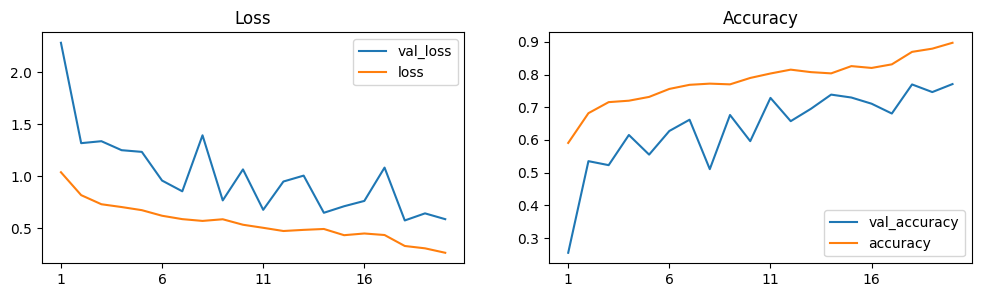

In [11]:
plot_performance("inception")

In [12]:
#Measure the final results
predictions = model_inception.predict(test_set)
inceptionV3_results = model_inception.evaluate(test_set)    

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 512ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - accuracy: 0.7749 - loss: 0.5882


In [13]:
print(f"Test accuracy: {inceptionV3_results[1]*100:.2f}%")

Test accuracy: 76.05%


2024-11-26 01:59:31.364997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


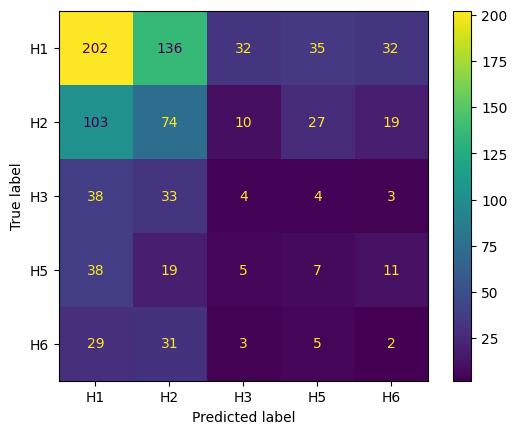

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = train_set.class_names

# true labels using test dataset
y_true = np.concatenate([label for pic, label in test_set], axis=0)

# final predicted labels 
y_pred = np.argmax(predictions, axis=1)

# showing the confusion matrix of the second model
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                            display_labels=class_names)
disp.plot()
plt.show()